In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import transformations as tf
import matplotlib.pyplot as plt
import open3d as o3d

In [2]:
import os
import os.path as osp

In [21]:
BASE_PATH = './data/result_chair2_run2'
keyframes = pd.read_csv(osp.join(BASE_PATH, 'keyframes_with_id.txt'), sep=' ')
objects = pd.read_csv(osp.join(BASE_PATH,'objects.txt'), sep=' ')
# apriltags = pd.read_csv('data/run1/result.csv', sep=' ')

In [22]:
def _get_tf_mat_from_row(drow):
    q = np.array(drow[['qw', 'qx', 'qy', 'qz']])
    t = np.array(drow[['x', 'y', 'z']]).reshape(3)
    T = tf.quaternion_matrix(q)
    T[:3, 3] = t
    return T

def add_tf_mat_to_df(df):
    df['T'] = df.apply(_get_tf_mat_from_row, axis=1)


In [23]:
add_tf_mat_to_df(keyframes)
add_tf_mat_to_df(objects)

In [49]:
objects['T'][0].shape

(4, 4)

In [27]:
# Load Pointclouds
pointclouds = {}
for i in objects['#id']:
    pointclouds[i] = o3d.io.read_point_cloud(osp.join(BASE_PATH, 'object_pointclouds', '{}.ply'.format(i)))

In [58]:
# Transform all points to local
def get_local_points(Two, points):
    Tow = np.linalg.inv(Two)
    points_homo = np.ones((points.shape[0], 4))
    points_homo[:,:3] = points
    points_homo = np.transpose(points_homo)
    outs = np.matmul(Tow, points_homo)
    return np.transpose(outs)[:, :3]

1.1319264258600958


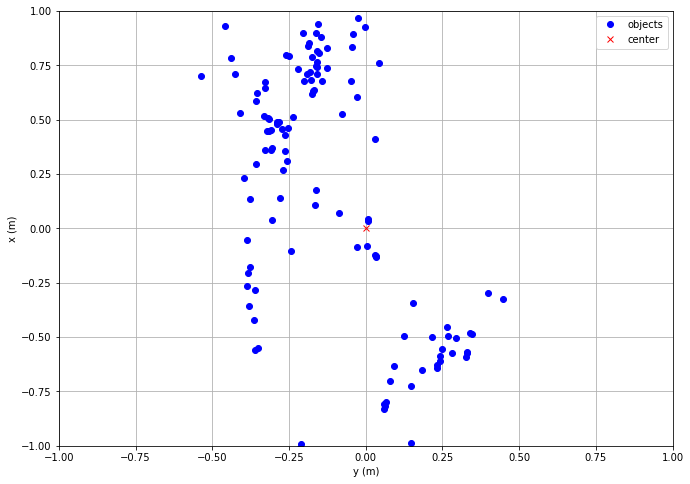

In [70]:
ID = 0
fragment = pointclouds[ID]
obj = objects[objects['#id'] == ID].iloc[0]
# points = np.asarray(fragment.points)
points = get_local_points(obj['T'], np.asarray(fragment.points))
# points = points[points[:,2] > 0.5]

# Note: must filter ground points out manually, because chairs can see ground
lowest_z = np.min(points[:, 2])
highest_z = np.max(points[:, 2])
print(highest_z - lowest_z)
points = points[ points[:, 2] > lowest_z + 0.7]
plt.figure(figsize=(11,8))
plt.xlabel('y (m)')
plt.ylabel('x (m)')
plt.xlim((-1,1))
plt.ylim((-1,1))
plt.grid(True)
# Draw points
plt.plot(points[:, 1], points[:, 0], 'ro', color='b', label='objects')
plt.plot(0, 0, 'rx', color='r', label='center')
plt.legend()